In [49]:
%pylab inline
import numpy as np
import pylab as pb
import GPy
import urllib
np.random.seed(2)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Hierachical Gaussian Process Example
This is a simple example of a hierachical GP over a toy data set, the theory to do this is in  http://www.biomedcentral.com/1471-2105/14/252

Initially we generate a simple sinusoidal signal, which for our undertsanding is the parent signal.

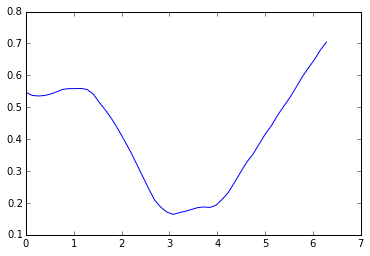

In [50]:
time_stamps = 50
x_parent = np.linspace(0, 2*np.pi, time_stamps)
# generationg the parent form a GP sample
kg = GPy.kern.Matern32(1, variance=1., lengthscale=10.)
#inp = np.arange(x_parent.shape[0])
inp = x_parent[:, None]
C_parent_gen = kg.K(inp, None)
g_mean = np.zeros(x_parent.shape[0])
g_n = np.random.multivariate_normal(g_mean, C_parent_gen, 1)
g_n = np.squeeze(g_n)
pb.plot(x_parent, g_n)

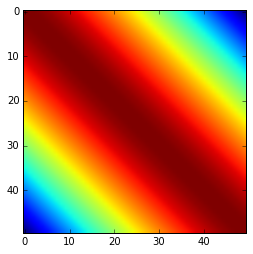

In [51]:
plt.imshow(C_parent_gen)

The we generate noise corrupted signals which are like "sons" from the original signal, to do this we only add to the original signal some  gaussian noise with mean zero and a standard deviation. We expect to recover the original signal using these as an input.

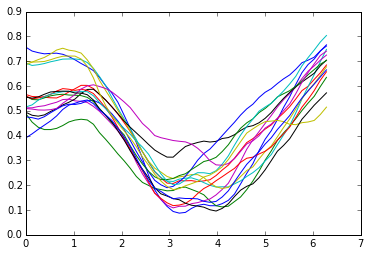

In [53]:
n_sons = 15
fn_list = []
kf = GPy.kern.Matern32(1, variance=0.01, lengthscale=2.)
C_sons_gen = kf.K(inp, None)
for i in range(0, n_sons):
    tmp = np.random.multivariate_normal(g_n, C_sons_gen, 1)
    tmp = np.squeeze(tmp)
    fn_list.append(tmp)
    pb.plot(inp, tmp)

Given the documentation, the way to consruct a Hierarchical Kernel to compute a hierarchical covariance one need to use GPy.kern._src.independent_outputs.Hierarchical(kernels), Which receives as an input a list of kernels, the size of that list indicates the deepest level of that hierarchy, for these case we only have one level or layer.

The input to the regression is:
* T_hat: all data in the input space as a column vector with an extra column indicating the corresponding output
* y_hat: all data in the output space(sinusoidal corrupted signal) as a column vector.
* HGP: Hierarchical Kernel

Documentation(Code): https://github.com/SheffieldML/GPy/blob/devel/GPy/kern/src/independent_outputs.py 

In [65]:
T_hat = np.r_[np.c_[inp, np.zeros_like(inp)]]
Y_hat = np.r_[np.c_[fn_list[0]]]
print Y_hat.shape
for i in range(1,n_sons):
    T_hat = np.r_[T_hat, np.c_[inp, np.ones_like(inp)*i]]
    Y_hat = np.r_[Y_hat, np.c_[fn_list[i]]]

k1 = GPy.kern.Matern32(1, variance=1., lengthscale=20.) # Kernel for the underlying trend
k2 = GPy.kern.Matern32(1, variance=1., lengthscale=5.) #+ GPy.kern.White(1, variance=0.1) # Kernel for the layer of noise corrupted signals
kernels = [k1,k2] 
HGP = GPy.kern._src.independent_outputs.Hierarchical(kernels)

(50, 1)


In [66]:
model = GPy.models.GPRegression(T_hat, Y_hat, HGP) # Making a normal regression
#model.likelihood.variance = 0.01
model.optimize('bfgs', messages=1)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s34  0001   7.493776e+02   4.965328e+04 
    02s26  0011  -2.604759e+03   3.697562e+03 
    06s55  0035  -2.626545e+03   1.358692e+05 
    17s45  0101  -2.770493e+03   1.874973e+02 
    20s01  0115  -2.770493e+03   1.911206e+02 
    21s05  0121  -2.770493e+03   1.938511e+02 
    21s94  0126  -2.770493e+03   1.938511e+02 
Runtime:     21s94
Optimization status: Converged



 /Users/juangilopez/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning:The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


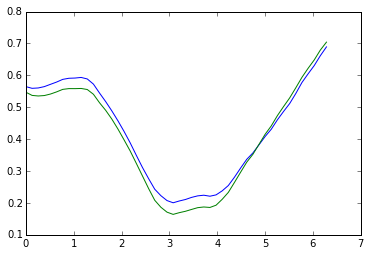

In [67]:
mu, mvar = model.predict(inp, kern=k1, full_cov=True)
pb.figure
pb.plot(inp, mu)
pb.plot(inp, g_n)

We make the regression in order to obtain the optimal parameters for the covariance functions, then we obtain the approximated noise corrupted signals.

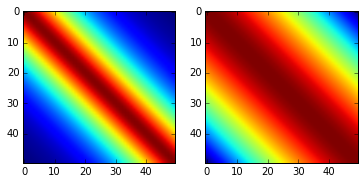

In [68]:
plt.subplot(1,2,1)
plt.imshow(mvar)
plt.subplot(1,2,2)
plt.imshow(C_parent_gen)

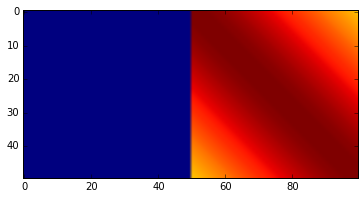

In [58]:
cov_comp = np.hstack([mvar,C_parent_gen])
pb.imshow(cov_comp)


Name                              : GP regression
Log-likelihood                    : 2764.72807579
Number of Parameters              : 5
Number of Optimization Parameters : 5
Updates                           : True
Parameters:
  GP_regression.                 |        Value        |  Constraint  |  Prior  |  Tied to
  hierarchy.Mat32_1.variance     |      6.00715028608  |     +ve      |         |         
  hierarchy.Mat32_1.lengthscale  |      18.5517697326  |     +ve      |         |         
  hierarchy.Mat32.variance       |    0.0149221273406  |     +ve      |         |         
  hierarchy.Mat32.lengthscale    |      2.25388021084  |     +ve      |         |         
  Gaussian_noise.variance        |  4.67173532151e-09  |     +ve      |         |         


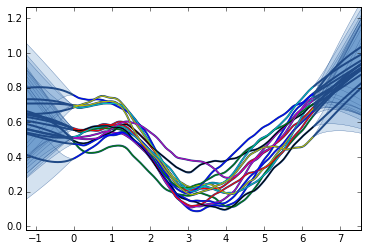

In [59]:
for i in range(n_sons):
        model.plot(fignum=1,fixed_inputs=[(1, i)], plot_raw=True)

for i in range(0, n_sons):
    pb.plot(inp, fn_list[i])

print model

Then the Hierarchical process covariance for this case have this shape

  hierarchy.           |       Value        |  Constraint  |  Prior  |  Tied to
  Mat32_1.variance     |      6.1626389395  |     +ve      |         |         
  Mat32_1.lengthscale  |     17.1478973501  |     +ve      |         |         
  Mat32.variance       |  0.00768543215314  |     +ve      |         |         
  Mat32.lengthscale    |     1.84854569578  |     +ve      |         |         


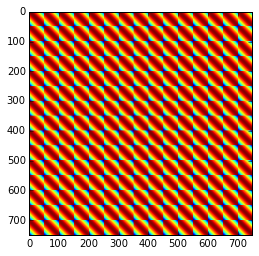

In [69]:
C = HGP.K(T_hat, None)
print HGP
plt.imshow(C)

## Computing the parent posterior given its children

AS we stated before what we want is to compute the posterior distribution for the parent signal given that we just observed it's children, then iniitially we compute the covariance matrix for the parent using the "optimized kernel"

### Prior of the parent

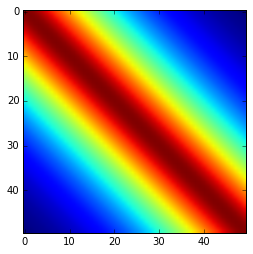

In [70]:
kernel_parent = model.kern.Mat32_1
inp = np.arange(inp.shape[0])
T = inp[:, None]
C_parent = kernel_parent.K(T, None)
plt.imshow(C_parent)
K_HGP = np.matrix(C)

We show the shape of the full joint covariance between the parent(the one we want to predict) and its sons(the ones we observed), then the posterior is computed using the next reasoning:

if $ \pmb{K_g}$:  Covariance of the parent signal, $ \pmb{K_{hgp}}$: Covariance of the sons using the hierarchical model, then the full joint distribution has mean zero and covariance:
$$ Cov = \begin{bmatrix}
    \pmb{K_{hgp}} & \pmb{K_{hgp,g}} \\
    \pmb{K_{g,hgp}} & \pmb{K_g} \\
\end{bmatrix}
$$
then the posterior distribution(predictive distribution) has:

$$\pmb{\mu_g{posterior}} = \pmb{K_{g,hgp}K_{hgp}^{-1}Y_{hat}} $$
$$\pmb{K_g{posterior}} = \pmb{K_g} - \pmb{K_{g,hgp}K_{hgp}^{-1}K_{hgp,g}} $$

(750, 50)


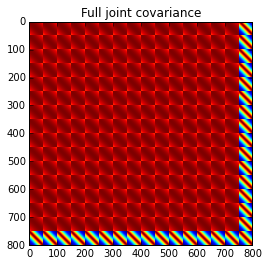

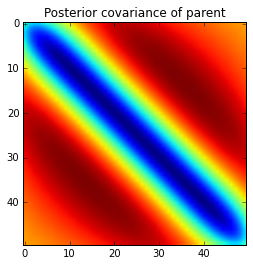

In [71]:
C_parlist = []
for i in range(0,n_sons):
    C_parlist.append(C_parent)

tmp_kg = np.vstack(C_parlist)
print tmp_kg.shape
full_K = np.vstack([np.hstack([K_HGP, tmp_kg]), np.hstack([tmp_kg.T, C_parent])])    
plt.figure(1)
plt.title('Full joint covariance')
plt.imshow(full_K)

posterior_mean = tmp_kg.T*np.linalg.inv(K_HGP)*Y_hat
posterior_cov = C_parent - (tmp_kg.T*np.linalg.inv(K_HGP)*tmp_kg)

plt.figure(2)
plt.title('Posterior covariance of parent')
plt.imshow(posterior_cov)
time_size = C_parent.shape[0]

Then the mean used to extract the predicted parent of the child signals(strange result)

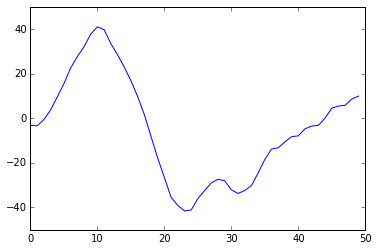

In [72]:
pb.plot(inp, posterior_mean)